In [1]:
import scanpy as sc
import scvelo as scv
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

SEED = 2024
np.random.seed(SEED)

### read adata from velocyto process (add u/s)

In [2]:
sample_palette = {
    'd5r1': '#a6cee3', 
    'd5r2': '#1f78b4',
    'd2_5':'#fdbf6f'}

celltype_palette = {
    'Baso/Eos/Mast':'#279e68',
    'Ccr7_DC':'#ff7f0e', 
    'Ery/Meg':"yellow", 
    'Lym':'#aec7e8',
    'Mono':'#d62728',
    'Neu':'#1f77b4', 
    'Other':"grey",
    'pDC':'#aa40fc'}
    

In [3]:
adata = sc.read_h5ad("/home/liyaru/DATA/8_transition/1_DATA/4_NBT_2023/LSK_velocity_RNAassay.h5ad")
print(adata)

AnnData object with n_obs × n_vars = 61695 × 29836
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'sample', 'S.Score', 'G2M.Score', 'Phase', 'integrated_snn_res.0.5', 'seurat_clusters', 'palantir_clusters', 'mono1', 'neu2', 'dc3', 'baso4', 'ery5', 'eos6', 'mep7', 'gmp8', 'cell_type', 'integrated_snn_res.0.4', 'integrated_snn_res.2', 'cell_type2', 'DF_score', 'DF_class', 'orig.lib', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced', 'nCount_ambiguous', 'nFeature_ambiguous'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'highly_variable_genes'
    obsm: 'X_cce', 'X_pal', 'X_pca', 'X_umap'
    layers: 'ambiguous', 'spliced', 'unspliced'


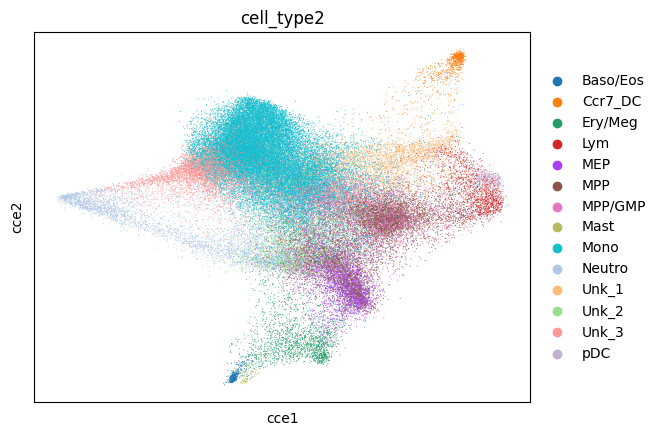

In [4]:
sc.pl.embedding(adata,color="cell_type2",basis='cce')

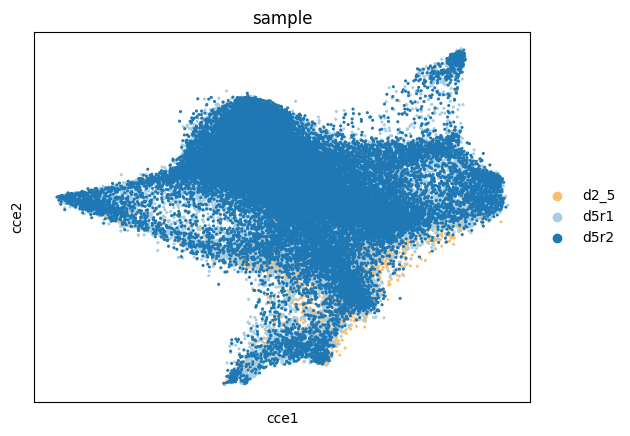

In [5]:
sc.pl.embedding(adata,color="sample",basis='cce',palette=sample_palette,size=20)

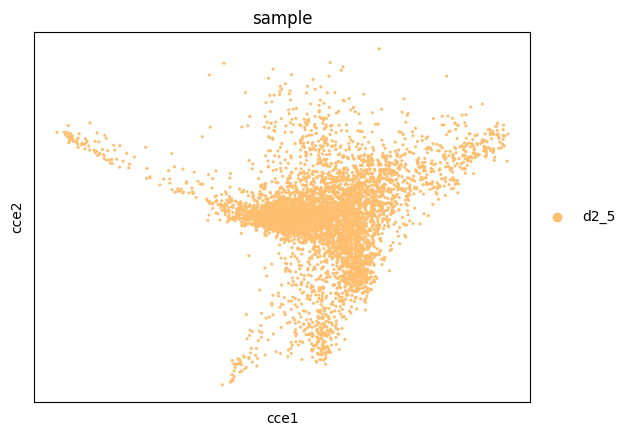

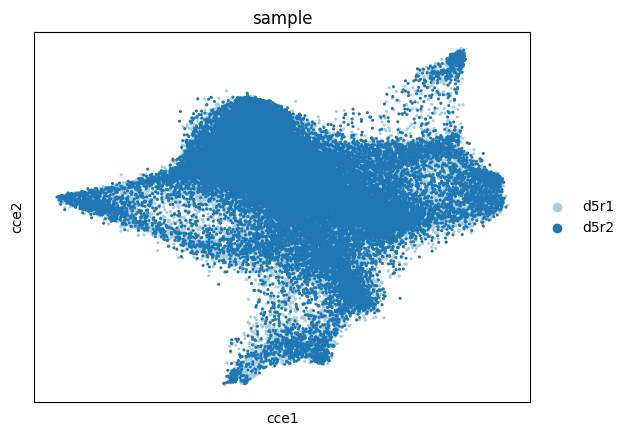

In [6]:
obs = adata.obs
d2 = obs[obs['sample'] == 'd2_5'].index
adata_d2 = adata[d2]
sc.pl.embedding(adata_d2,color="sample",basis='cce',palette=sample_palette,size=20,save='cce_d2.pdf')

d5 = obs[obs['sample'] != 'd2_5'].index
adata_d5 = adata[d5]
sc.pl.embedding(adata_d5,color="sample",basis='cce',palette=sample_palette,size=20,save='cce_d5.pdf')

### filter by RNA assay and clone info

In [7]:
clone = pd.read_csv("/home/liyaru/DATA/8_transition/1_DATA/4_NBT_2023/potential_cell_transfer_pair.csv")
clone['Cell1'] = clone['Cell1'].str.replace('-rna', '', regex=True)
clone['Cell2'] = clone['Cell2'].str.replace('-rna', '', regex=True)

clone['Cell1'] = clone['Cell1'].apply(lambda x: x + '-rna')
clone['Cell2'] = clone['Cell2'].apply(lambda x: x + '-rna')

unique_cell1 = clone['Cell1'].unique()
unique_cell2 = clone['Cell2'].unique()
cell_all = list(set(unique_cell1) | set(unique_cell2))

cell_all_intersect = set(adata.obs.index).intersection(set(cell_all))

# filter clone
clone = clone[clone['Cell1'].isin(list(cell_all_intersect)) & clone['Cell2'].isin(list(cell_all_intersect))  ]

# filter adata
adata = adata[list(cell_all_intersect)]
print(adata)

View of AnnData object with n_obs × n_vars = 11733 × 29836
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'sample', 'S.Score', 'G2M.Score', 'Phase', 'integrated_snn_res.0.5', 'seurat_clusters', 'palantir_clusters', 'mono1', 'neu2', 'dc3', 'baso4', 'ery5', 'eos6', 'mep7', 'gmp8', 'cell_type', 'integrated_snn_res.0.4', 'integrated_snn_res.2', 'cell_type2', 'DF_score', 'DF_class', 'orig.lib', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced', 'nCount_ambiguous', 'nFeature_ambiguous'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'highly_variable_genes'
    uns: 'cell_type2_colors', 'sample_colors'
    obsm: 'X_cce', 'X_pal', 'X_pca', 'X_umap'
    layers: 'ambiguous', 'spliced', 'unspliced'


### plot clone

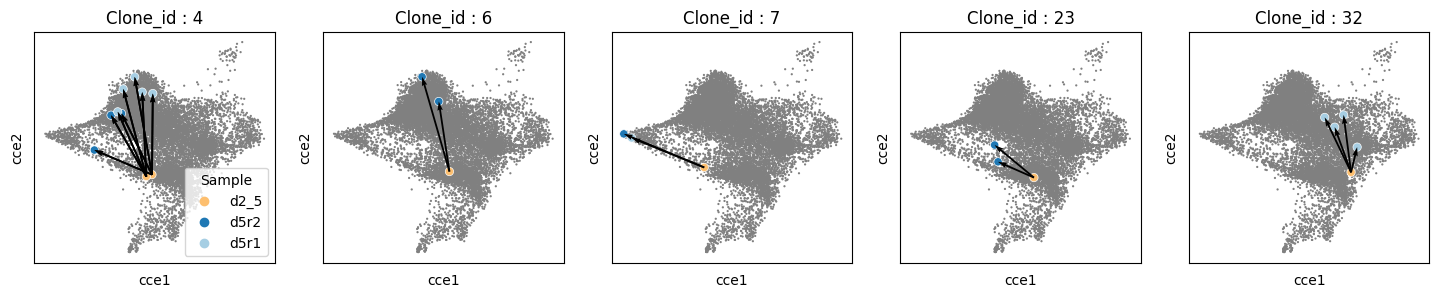

In [8]:
fig=plt.figure(figsize=(18,3))
gs = GridSpec(1,5)

for i in range(0,5):
    ax=plt.subplot(gs[i])

    clone_id = clone['clone.id'].unique()[i]
    c1 = clone.loc[clone['clone.id'] == clone_id,'Cell1'].tolist()
    c2 = clone.loc[clone['clone.id'] == clone_id,'Cell2'].tolist()
    c = c1 + c2
    c = list(set(c))

    sc.pl.scatter(adata,ax=ax,basis="cce", show=False)

    coords_curr_x = adata.obsm['X_cce'][adata.obs.index.isin(c),0]
    coords_curr_y = adata.obsm['X_cce'][adata.obs.index.isin(c),1]
    coords_celltype = adata.obs.loc[adata.obs.index.isin(c),'sample']

    df_curr = pd.DataFrame((coords_curr_x,coords_curr_y, coords_celltype), index=['x','y','hue']).T

    c1 = list(set(c1)) * len(c2)
    coords_curr_x11 = adata.obsm['X_cce'][adata.obs.index.isin(c1),0].tolist()
    coords_curr_x12 = adata.obsm['X_cce'][adata.obs.index.isin(c1),1].tolist()
    coords_curr_x21 = adata.obsm['X_cce'][adata.obs.index.isin(c2),0].tolist()
    coords_curr_x22 = adata.obsm['X_cce'][adata.obs.index.isin(c2),1].tolist()

    x11 = np .array(coords_curr_x11 * len(coords_curr_x21))
    x12 = np .array(coords_curr_x12 * len(coords_curr_x22))
    x21 = np .array(coords_curr_x21 * len(coords_curr_x11))
    x22 = np .array(coords_curr_x22 * len(coords_curr_x12))

    # v1 =  [x - y for x, y in zip(x21, x11)]
    # v2 = [x - y for x, y in zip(x22, x12)]
    v1 =  x21 - x11
    v2 = x22 - x12

    if i ==0: # add legend
        sns.scatterplot(x='x', y='y', hue='hue', data=df_curr,palette=sample_palette)
        plt.legend(title="Sample", loc='lower right')
        plt.title("Clone_id : " + str(clone_id))
        ax.quiver(x11,x12,v1,v2,scale_units="xy",scale=1,angles="xy")


    else:
        sns.scatterplot(x='x', y='y', hue='hue', data=df_curr,palette=sample_palette,legend=False)
        plt.title("Clone_id : " + str(clone_id))
        ax.quiver(x11,x12,v1,v2,scale_units="xy",scale=1,angles="xy")
        
plt.savefig('clone_eg.pdf')

Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.


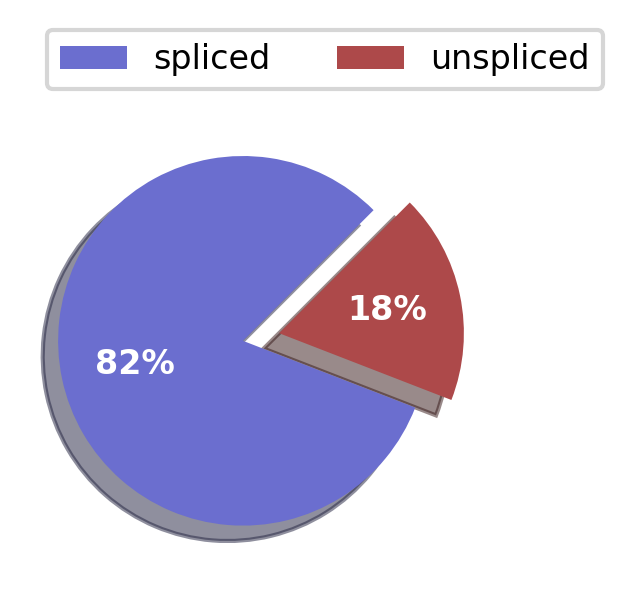

computing neighbors
    finished (0:00:30) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:04) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
        Consider computing the graph in an unbiased manner 
        on full expression space by not specifying basis.

computing velocity graph (using 10/20 cores)


  0%|          | 0/11733 [00:00<?, ?cells/s]

    finished (0:00:20) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:02) --> added
    'velocity_cce', embedded velocity vectors (adata.obsm)


ValueError: color key is invalid! pass valid observation annotation or a gene name

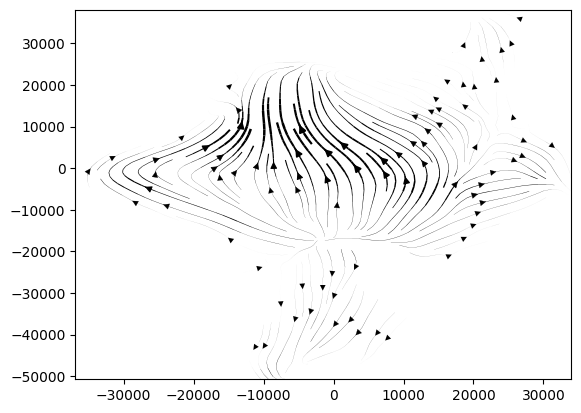

In [9]:
scv.pp.filter_and_normalize(adata,n_top_genes=2000)
scv.pl.proportions(adata,dpi=300)
scv.pp.moments(adata)

scv.tl.velocity(adata, mode='stochastic')
scv.tl.velocity_graph(adata,vkey="velocity",n_jobs=10,basis= "cce")
scv.pl.velocity_embedding_stream(adata,basis= "cce",color="celltype",palette = celltype_palette)

### cell pair cosine similarity

In [ ]:
cell1_list = clone['Cell1'].unique().tolist()
results_df = pd.DataFrame(columns=['cosine_similarity'])

v_s = pd.DataFrame(adata.layers['velocity'],columns =  adata.var.index.tolist(),index = adata.obs.index)
# v_s = pd.DataFrame(adata_sub.layers['velocity'],columns =  adata_sub.var.index.tolist(),index = adata_sub.obs.index)
v_s = v_s.dropna(axis=1, how='all')

s = pd.DataFrame.sparse.from_spmatrix(adata.X, columns=adata.var.index.tolist(), index=adata.obs.index)
# s = pd.DataFrame(adata.layers['Ms'], columns=adata.var.index.tolist(), index=adata.obs.index)
# s = pd.DataFrame.sparse.from_spmatrix(adata.layers['spliced'], columns=adata.var.index.tolist(), index=adata.obs.index)
s = s.loc[:,v_s.columns]

cos_sim_max_list = []
cos_sim_max_cell2_list = []

cos_sim_random_list = []
cos_sim_random_cell2_list = []

cos_sim_exp_list = []
cos_sim_exp_cell2_list = []


i = 0

for cell1 in cell1_list:

    cell2 = clone.loc[clone['Cell1']==cell1,'Cell2'].tolist()
    
    s1 = s.loc[cell1]
    s2 = s.loc[cell2]
    
    diff_s = s2.subtract(s1, axis=1)
    
    v = v_s.loc[cell1].to_frame().T
    
    cos_sim = cosine_similarity(diff_s ,v).flatten()

    # cell pair v vs cal v, max cosine sim
    max_value = max(cos_sim)
    max_index = np.argmax(cos_sim)
    cell2_max = cell2[max_index]    
    cos_sim_max_list.append(max_value)
    cos_sim_max_cell2_list.append(cell2_max)

    # random cell pair
    random_value = np.random.choice(cos_sim)
    random_index = np.where(cos_sim == random_value)[0][0]
    cell2_random = cell2[random_index]    
    cos_sim_random_list.append(random_value)
    cos_sim_random_cell2_list.append(cell2_random)

    # max exp cosine sim
    cos_sim2 = cosine_similarity(s1.to_frame().T,s2).flatten()
    max_value = max(cos_sim2)
    max_index = np.argmax(cos_sim2)
    cell2_max = cell2[max_index]    
    cos_sim_exp_list.append(max_value)
    cos_sim_exp_cell2_list.append(cell2_max)


    if i % 100 == 0:
        print(i)
    
    i += 1

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700


In [ ]:
cell_list = list(set(cos_sim_exp_cell2_list + cell1_list))
adata_cell1_and_cell2 = adata[cell_list]

adata_cell1_and_cell2.uns['cell1_list'] = cell1_list
adata_cell1_and_cell2.uns['cell2_list_exp'] = cos_sim_exp_cell2_list
adata_cell1_and_cell2.uns['cos_sim_exp_list'] = cos_sim_exp_list
adata_cell1_and_cell2.uns['cos_sim_random_list'] = cos_sim_random_list
adata_cell1_and_cell2.uns['cos_sim_max_list'] = cos_sim_max_list

scv.pp.neighbors(adata_cell1_and_cell2)
scv.pp.moments(adata_cell1_and_cell2)

print(adata_cell1_and_cell2)
adata_cell1_and_cell2.write_h5ad("LSK_lineage.h5ad")

computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
AnnData object with n_obs × n_vars = 3186 × 2000
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'sample', 'S.Score', 'G2M.Score', 'Phase', 'integrated_snn_res.0.5', 'seurat_clusters', 'palantir_clusters', 'mono1', 'neu2', 'dc3', 'baso4', 'ery5', 'eos6', 'mep7', 'gmp8', 'cell_type', 'integrated_snn_res.0.4', 'integrated_snn_res.2', 'cell_type2', 'DF_score', 'DF_class', 'orig.lib', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced', 'nCount_ambiguous', 'nFeature_ambiguous', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
        Consider computing the graph in an unbiased manner 
        on full expression space by not specifying basis.

computing velocity graph (using 15/20 cores)


/home/liyaru/miniconda3/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/1756 [00:00<?, ?cells/s]

    finished (0:00:10) --> added 
    'ground_truth_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'ground_truth_velocity_cce', embedded velocity vectors (adata.obsm)


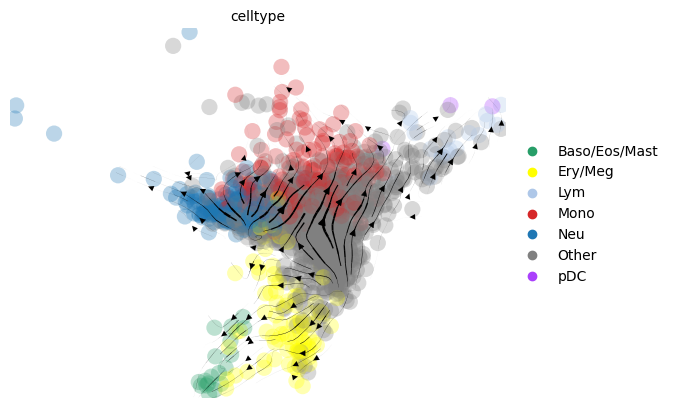

AnnData object with n_obs × n_vars = 1756 × 2000
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'sample', 'S.Score', 'G2M.Score', 'Phase', 'integrated_snn_res.0.5', 'seurat_clusters', 'palantir_clusters', 'mono1', 'neu2', 'dc3', 'baso4', 'ery5', 'eos6', 'mep7', 'gmp8', 'cell_type', 'integrated_snn_res.0.4', 'integrated_snn_res.2', 'cell_type2', 'DF_score', 'DF_class', 'orig.lib', 'nCount_spliced', 'nFeature_spliced', 'nCount_unspliced', 'nFeature_unspliced', 'nCount_ambiguous', 'nFeature_ambiguous', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'ground_truth_velocity_self_transition'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'cell

In [ ]:
s1 = s.loc[cell1_list,]
# s2 = s.loc[cos_sim_random_cell2_list,]
s2 = s.loc[cos_sim_exp_cell2_list,]
v = s2.values - s1.values

adata_sub = adata[s1.index,s1.columns]
adata_sub.layers['ground_truth_velocity'] = v

scv.pp.neighbors(adata_sub)
scv.tl.velocity_graph(adata_sub,vkey='ground_truth_velocity',basis="cce",n_jobs=15)

scv.pl.velocity_embedding_stream(adata_sub,basis = "cce",
                                 vkey='ground_truth_velocity',legend_loc = "right",
                                 color='celltype',
                                 palette = celltype_palette)

print(adata_sub)
adata_sub.write_h5ad("LSK_lineage_cell1_ground_truth.h5ad")

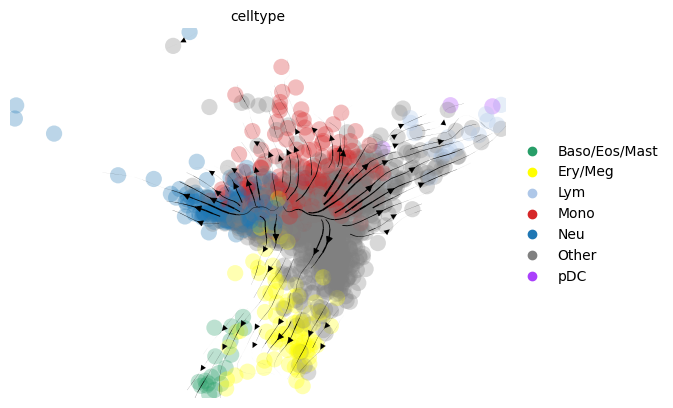

In [ ]:
scv.pl.velocity_embedding_stream(adata_sub, color='celltype',basis = "cce",
                                 vkey='velocity',legend_loc = "right",
                                 palette = celltype_palette)

### plot velocity example on single cell

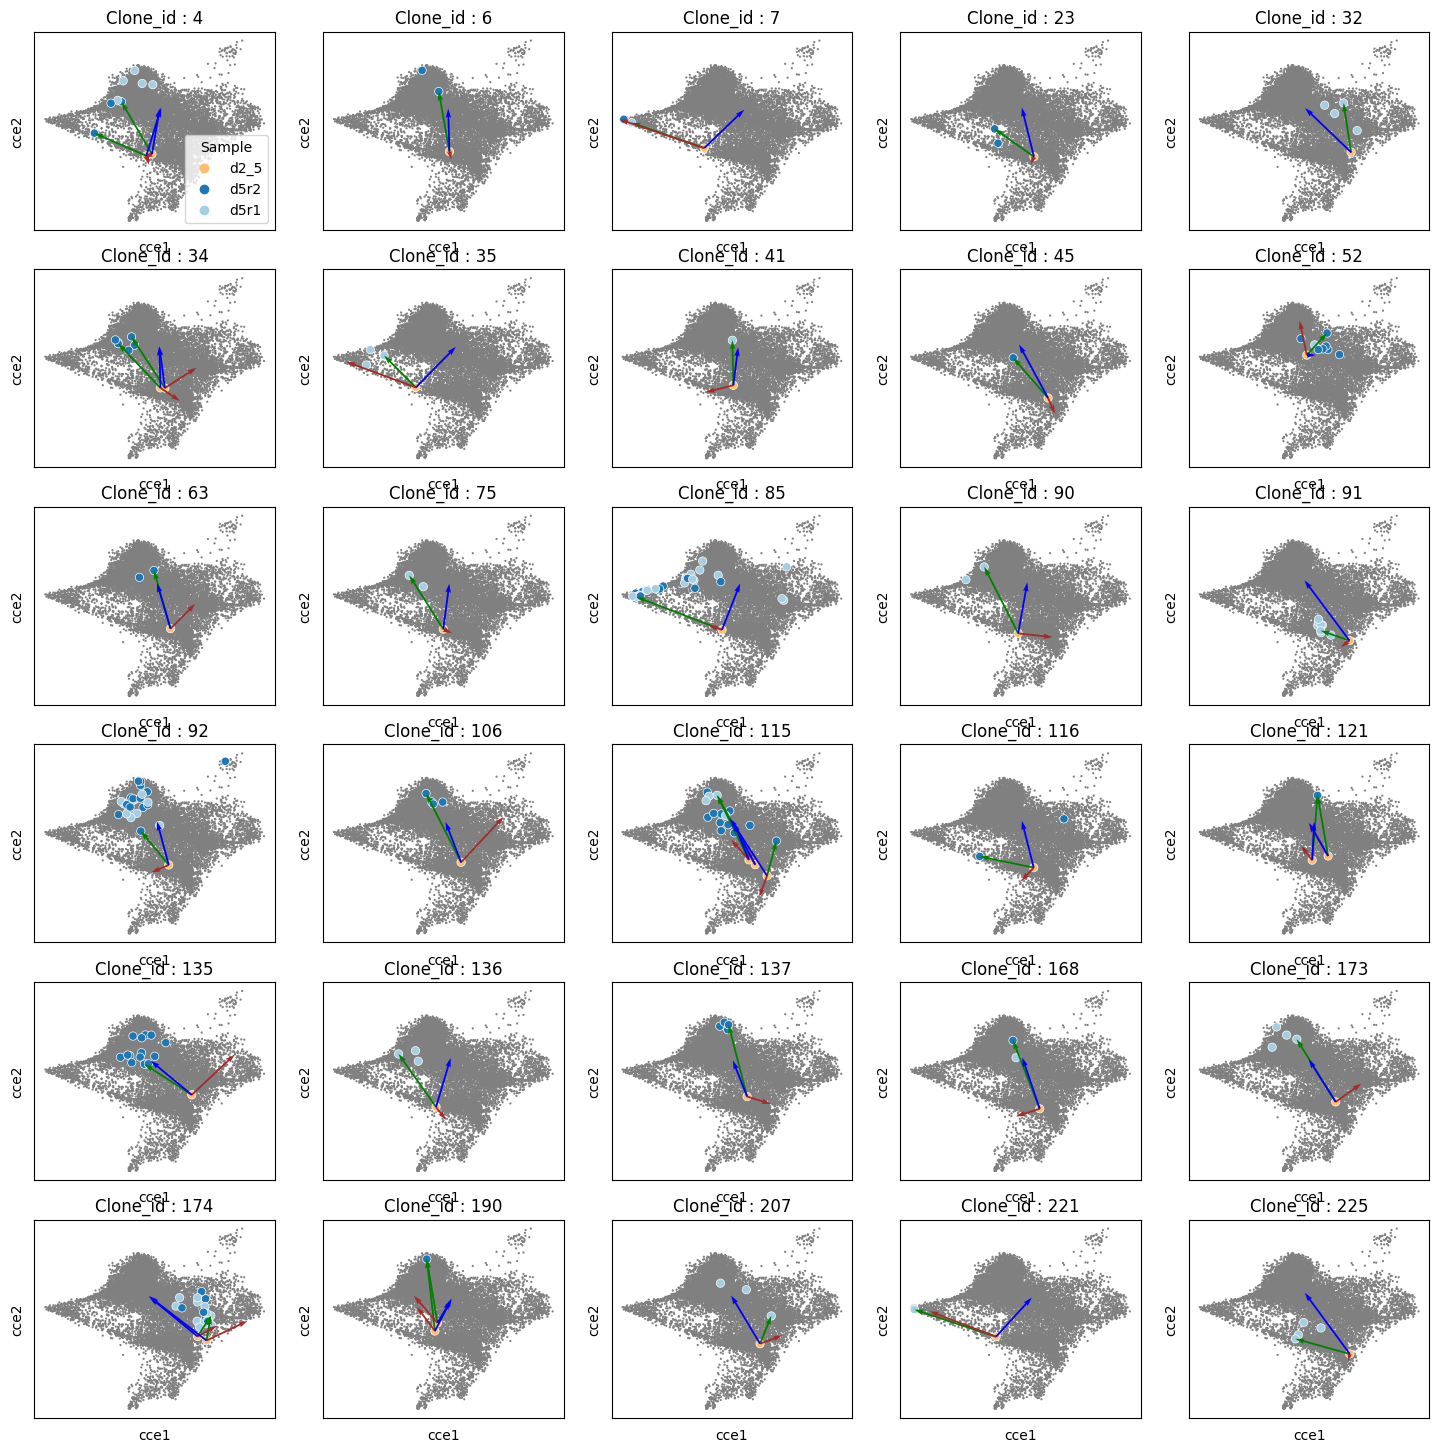

In [ ]:
fig=plt.figure(figsize=(18,18))
gs = GridSpec(6,5)

for i in range(0,30):
    ax=plt.subplot(gs[i])

    # all clone
    clone_id = clone['clone.id'].unique()[i]
    c1 = clone.loc[clone['clone.id'] == clone_id,'Cell1'].tolist()
    c2 = clone.loc[clone['clone.id'] == clone_id,'Cell2'].tolist()
    c = c1 + c2
    c = list(set(c))
    coords_curr_x = adata.obsm['X_cce'][adata.obs.index.isin(c),0]
    coords_curr_y = adata.obsm['X_cce'][adata.obs.index.isin(c),1]
    coords_celltype = adata.obs.loc[adata.obs.index.isin(c),'sample']
    df_curr = pd.DataFrame((coords_curr_x,coords_curr_y, coords_celltype), index=['x','y','hue']).T
    
    # arrow : cell1 to cell2
    cell1 = list(set(c1))
    cell1_index =  [index for index, element in enumerate(cell1_list) if (element in cell1)]
    cell2 = [cos_sim_max_cell2_list[i] for i in cell1_index] 
    x11 = adata[cell1].obsm['X_cce'][:,0]
    x12 = adata[cell1].obsm['X_cce'][:,1]
    x21 = adata[cell2].obsm['X_cce'][:,0]
    x22 = adata[cell2].obsm['X_cce'][:,1]
    v1 =  x21 - x11
    v2 = x22 - x12

    # arrow : cell1 cal velocity
    v_x11 =  adata[cell1].obsm['velocity_cce'][:,0].toarray()
    v_x12 = adata[cell1].obsm['velocity_cce'][:,1].toarray()

    # arrow : cell1 to cell2 velocity map in low dim
    map_x21 = adata_sub[cell1].obsm['ground_truth_velocity_cce'][:,0]
    map_x22 = adata_sub[cell1].obsm['ground_truth_velocity_cce'][:,1]
    map_v1 =  map_x21 - x11
    map_v2 = map_x22 - x12

    # plot
    sc.pl.scatter(adata,ax=ax,basis="cce", show=False)

    if i ==0: # add legend
        sns.scatterplot(x='x', y='y', hue='hue', data=df_curr,palette=sample_palette)
        plt.legend(title="Sample", loc='lower right')
        plt.title("Clone_id : " + str(clone_id))
        ax.quiver(x11,x12,v1,v2,scale_units="xy",scale=1,angles="xy",color="green") # cell1 directly to cell2
        ax.quiver(x11,x12,v_x11,v_x12,scale_units="xy",angles="xy",scale=0.006,color="brown") # calculate cell1 velocity
        ax.quiver(x11,x12,map_v1,map_v2,scale_units="xy",angles="xy",scale=0.8,color="blue") # cell2 - cell1 map in low dim

    else:
        sns.scatterplot(x='x', y='y', hue='hue', data=df_curr,palette=sample_palette,legend=False)
        plt.title("Clone_id : " + str(clone_id))
        ax.quiver(x11,x12,v1,v2,scale_units="xy",scale=1,angles="xy",color="green")
        ax.quiver(x11,x12,v_x11,v_x12,scale_units="xy",angles="xy",scale=0.006,color="brown")
        ax.quiver(x11,x12,map_v1,map_v2,scale_units="xy",angles="xy",scale=0.8,color="blue")